## Run on IBM Cloud

The cell below runs our U3Ry circuit on as many 4+ qubit devices as we can get. Set the `jobs` flag to a list of job ids to retrieve previous runs instead of queueing new trials.

In [5]:
%%bash

python examples/g14_on_ibm/run_ibm.py \
    --account=full \
    --shots=1024 \
    --circuit=data/g14_constrained_u3ry/g14_state.json \
    --jobs=data/g14_constrained_u3ry/u3ry_jobs.txt

2023-09-07 09:57:43,880	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


Loaded account full
Retrieved job cjsb5mftoe8ecf8p5o10 for backend ibmq_mumbai
Retrieved job cjsb5jmiel5ovfdojlqg for backend ibm_hanoi
Retrieved job cjsb5jkiifjafcoacbb0 for backend ibmq_guadalupe
Retrieved job cjsb5mmiel5ovfdojoj0 for backend ibmq_manila
Retrieved job cjsb5nnp8blo0km91kg0 for backend ibm_nairobi
Retrieved job cjsb5lnp8blo0km91iog for backend ibm_cairo
Processing results for ibmq_mumbai
Making df for ibmq_mumbai
Retrieved job cjsb5lak1qvd8tcm9mh0 for backend ibmq_belemRetrieved job cjsb5mvtoe8ecf8p5ob0 for backend ibmq_lima
Processing results for ibm_hanoi
Retrieved job cjsb5jik1qvd8tcm9kt0 for backend ibmq_jakarta

Making df for ibm_hanoiProcessing results for ibmq_guadalupeRetrieved job cjsb5kciifjafcoacbv0 for backend ibmq_quito

Retrieved job cjsb5k7toe8ecf8p5lr0 for backend ibm_auckland

Processing results for ibm_nairobi
Finished ibmq_mumbai
Processing results for ibm_cairo
Making df for ibm_nairobiMaking df for ibmq_guadalupe

Processing results for ibmq_manila

100%|██████████| 11/11 [00:08<00:00,  1.25it/s]


Retrieved results
Aggregating


## Processing

We'll calculate the win rate per question, as well as retrieve chip information for each device.

In [53]:
%load_ext autoreload
%autoreload 2

from functools import cache

import pandas as pd
import numpy as np

from qiskit_ibm_provider import IBMProvider

provider = IBMProvider(name='full')

df = pd.read_csv('data/g14_constrained_u3ry/ibm_results.csv')
df['qtype'] = np.where(df.va == df.vb, 'Vertex', 'Edge')
df['winrate'] = df.win * df.n / df.shots

@cache
def get_backend_config(backend: str):
    dev = provider.get_backend(backend)
    config = dev.configuration()
    qubits = config.n_qubits
    version = config.backend_version
    return qubits, version

for backend in df.backend.unique():
    qubits, version = get_backend_config(backend)
    df.loc[df.backend == backend, 'qubits'] = qubits
    df.loc[df.backend == backend, 'version'] = version

for job_id in df.job.unique():
    job = provider.retrieve_job(job_id)
    time = job.time_per_step()['running']
    df.loc[df.job == job_id, 'time'] = time

df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,va,vb,ca,cb,win,n,job,backend,shots,qtype,winrate,qubits,version,time
0,0,0,0,0,1,200,cjsb5jik1qvd8tcm9kt0,ibmq_jakarta,1024,Vertex,0.195312,7.0,1.4.0,2023-09-06 14:54:20.039000-04:00
1,0,0,1,0,0,19,cjsb5jik1qvd8tcm9kt0,ibmq_jakarta,1024,Vertex,0.000000,7.0,1.4.0,2023-09-06 14:54:20.039000-04:00
2,0,0,2,0,0,35,cjsb5jik1qvd8tcm9kt0,ibmq_jakarta,1024,Vertex,0.000000,7.0,1.4.0,2023-09-06 14:54:20.039000-04:00
3,0,0,3,0,0,12,cjsb5jik1qvd8tcm9kt0,ibmq_jakarta,1024,Vertex,0.000000,7.0,1.4.0,2023-09-06 14:54:20.039000-04:00
4,0,0,0,1,0,38,cjsb5jik1qvd8tcm9kt0,ibmq_jakarta,1024,Vertex,0.000000,7.0,1.4.0,2023-09-06 14:54:20.039000-04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15483,12,13,3,2,1,16,cjsb5nnp8blo0km91kg0,ibm_nairobi,1024,Edge,0.015625,7.0,1.3.3,2023-09-06 13:15:48.246000-04:00
15484,12,13,0,3,1,89,cjsb5nnp8blo0km91kg0,ibm_nairobi,1024,Edge,0.086914,7.0,1.3.3,2023-09-06 13:15:48.246000-04:00
15485,12,13,1,3,1,124,cjsb5nnp8blo0km91kg0,ibm_nairobi,1024,Edge,0.121094,7.0,1.3.3,2023-09-06 13:15:48.246000-04:00
15486,12,13,2,3,1,26,cjsb5nnp8blo0km91kg0,ibm_nairobi,1024,Edge,0.025391,7.0,1.3.3,2023-09-06 13:15:48.246000-04:00


In [54]:
def f(df:pd.DataFrame):
    df['q_winrate'] = df.winrate.sum()
    df = df.drop(columns=['winrate', 'win', 'n', 'ca', 'cb'])
    return df

df = df.groupby(['backend', 'va', 'vb'], group_keys=False).apply(f).drop_duplicates()
df.to_csv('data/g14_constrained_u3ry/ibm_processed.csv', index=False)
df

,va,vb,job,backend,shots,qtype,qubits,version,time,q_winrate
0,0,0,cjsb5jik1qvd8tcm9kt0,ibmq_jakarta,1024,Vertex,7.0,1.4.0,2023-09-06 14:54:20.039000-04:00,0.636719
16,1,1,cjsb5jik1qvd8tcm9kt0,ibmq_jakarta,1024,Vertex,7.0,1.4.0,2023-09-06 14:54:20.039000-04:00,0.648438
32,2,2,cjsb5jik1qvd8tcm9kt0,ibmq_jakarta,1024,Vertex,7.0,1.4.0,2023-09-06 14:54:20.039000-04:00,0.649414
48,3,3,cjsb5jik1qvd8tcm9kt0,ibmq_jakarta,1024,Vertex,7.0,1.4.0,2023-09-06 14:54:20.039000-04:00,0.634766
64,4,4,cjsb5jik1qvd8tcm9kt0,ibmq_jakarta,1024,Vertex,7.0,1.4.0,2023-09-06 14:54:20.039000-04:00,0.665039
...,...,...,...,...,...,...,...,...,...,...
15408,8,13,cjsb5nnp8blo0km91kg0,ibm_nairobi,1024,Edge,7.0,1.3.3,2023-09-06 13:15:48.246000-04:00,0.867188
15424,9,13,cjsb5nnp8blo0km91kg0,ibm_nairobi,1024,Edge,7.0,1.3.3,2023-09-06 13:15:48.246000-04:00,0.912109
15440,10,13,cjsb5nnp8blo0km91kg0,ibm_nairobi,1024,Edge,7.0,1.3.3,2023-09-06 13:15:48.246000-04:00,0.904297
15456,11,13,cjsb5nnp8blo0km91kg0,ibm_nairobi,1024,Edge,7.0,1.3.3,2023-09-06 13:15:48.246000-04:00,0.869141


Export hanoi data to produce a graph in another notebook

In [60]:
data = df.loc[df.backend == 'ibm_hanoi'].copy()
data = data.rename(columns=lambda s: 'win_rate' if s == 'q_winrate' else s)
data.to_csv('data/g14_constrained_u3ry/g14_winrate_ibm_hanoi.csv', index=False)

## Plotting

This is a plot of all the devices by question type. Notice the disparity in vertex vs. edge questions.

In [55]:
df = pd.read_csv('data/g14_constrained_u3ry/ibm_processed.csv')

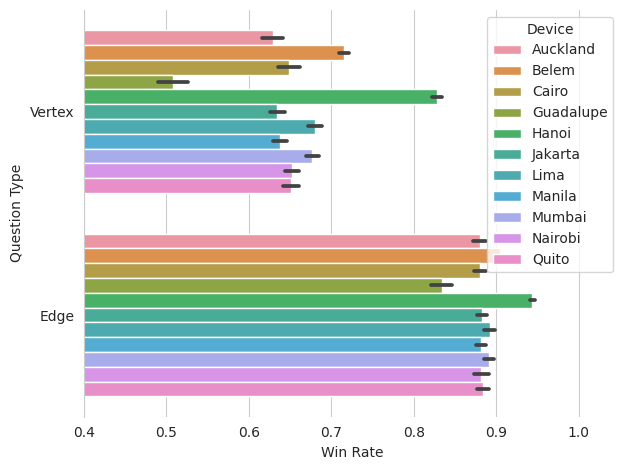

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('pastel')
sns.set_style('whitegrid')

df['Device'] = df.backend.apply(lambda s: s.split('_')[1].title())

sns.barplot(data=df, x='q_winrate', y='qtype', hue='Device', hue_order=sorted(df.Device.unique()))
plt.xlabel('Win Rate')
plt.xlim(0.4, 1.05)
plt.ylabel('Question Type')
sns.despine(bottom=True)
plt.tight_layout()
plt.savefig('plots/g14_constrained_u3ry/all_devices_byquestion.png', dpi=300)
plt.savefig('plots/g14_constrained_u3ry/all_devices_byquestion.pdf')
plt.show()

Plot the subset of 27-qubit devices.

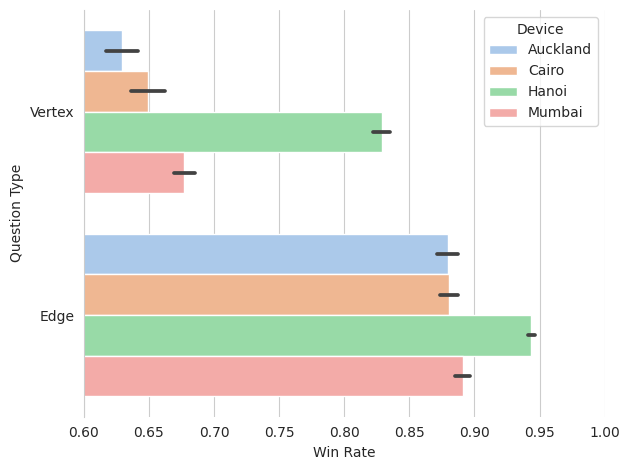

In [57]:
data = df.loc[df.qubits == 27]

sns.barplot(data=data,
            x='q_winrate',
            y='qtype',
            hue='Device',
            hue_order=sorted(data.Device.unique()))
plt.xlabel('Win Rate')
plt.xlim(0.6, 1.0)
plt.ylabel('Question Type')
sns.despine(bottom=True)
plt.tight_layout()
plt.savefig('plots/g14_constrained_u3ry/27q_devices_byquestion.png', dpi=300)
plt.savefig('plots/g14_constrained_u3ry/27q_devices_byquestion.pdf')
plt.show()